In [1]:
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import CuDNNLSTM, LSTM, Dropout

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

import renom as rm
from renom.optimizer import Adam
from renom.cuda import set_cuda_active
set_cuda_active(True)

import pywt

Using TensorFlow backend.


length of ECG data :  45000


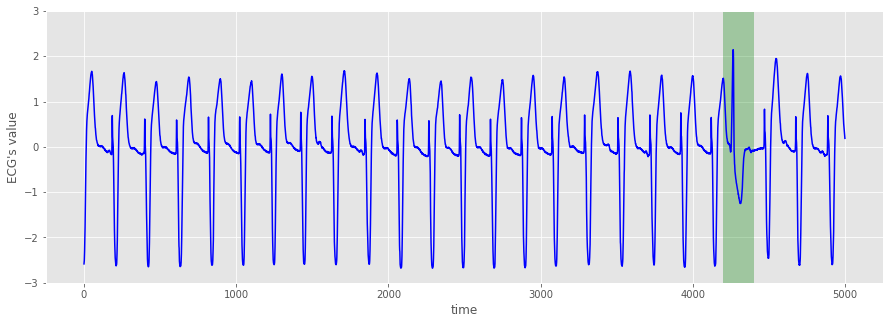

In [2]:
df = pd.read_csv('qtdbsel102.txt', header=None, delimiter='\t')
ecg = df.iloc[:,2].values
ecg = ecg.reshape(len(ecg), -1)
print('length of ECG data : ', len(ecg))

# standardize
scaler = StandardScaler()
std_ecg = scaler.fit_transform(ecg)

plt.style.use('ggplot')
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('ECG\'s value')
plt.plot(np.arange(5000), std_ecg[:5000], color='b')
plt.ylim(-3, 3)
x = np.arange(4200,4400)
y1 = [-3]*len(x)
y2 = [3]*len(x)
plt.fill_between(x, y1, y2, facecolor='g', alpha=.3)
plt.show()

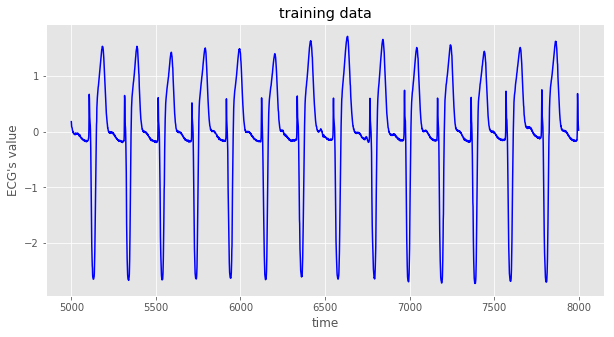

In [3]:
normal_cycle = std_ecg[5000:]

plt.figure(figsize=(10,5))
plt.title("training data")
plt.xlabel('time')
plt.ylabel('ECG\'s value')
plt.plot(np.arange(5000,8000), normal_cycle[:3000], color='b')# stop plot at 8000 times for friendly visual
plt.show()

In [4]:
# create data of the "look_back" length from time-series, "ts"
# and the next "pred_length" values as labels
def create_subseq(ts, look_back, pred_length):
    sub_seq, next_values = [], []
    for i in range(len(ts)-look_back-pred_length):  
        sub_seq.append(ts[i:i+look_back])
        next_values.append(ts[i+look_back:i+look_back+pred_length].T[0])
    return sub_seq, next_values

In [5]:
normal_cycle.shape

(40000, 1)

In [6]:
look_back = 10
pred_length = 3
n_neurons = 16
n_batch = 32
sub_seq, next_values = create_subseq(normal_cycle, look_back, pred_length)


X_train, X_test, y_train, y_test = train_test_split(
    sub_seq, next_values, test_size=0.2)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


train_size = X_train.shape[0]
test_size = X_test.shape[0]
print('train size:{}, test size:{}'.format(train_size, test_size))

train size:31989, test size:7998


In [7]:
# design network
model = Sequential()
model.add(CuDNNLSTM(n_neurons, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(CuDNNLSTM(n_neurons, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.4))
model.add(CuDNNLSTM(n_neurons, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.4))
model.add(Dense(y_train.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
#for i in range(n_epochs):
#	model.fit(train_x, train_y, epochs=1, batch_size=n_batch, verbose=2, shuffle=False)
#	print('epoch',i)
#	model.reset_states()
history = model.fit(X_train,
          y_train,
          n_batch,
          nb_epoch=10,
          validation_split=0.1,
          verbose=1)    



Train on 28790 samples, validate on 3199 samples
Epoch 1/10
28790/28790 [==============================] - 10s 347us/step - loss: 0.2120 - val_loss: 0.0272
Epoch 2/10
28790/28790 [==============================] - 10s 357us/step - loss: 0.0841 - val_loss: 0.0190
Epoch 3/10
28790/28790 [==============================] - 8s 281us/step - loss: 0.0728 - val_loss: 0.0160
Epoch 4/10
28790/28790 [==============================] - 8s 275us/step - loss: 0.0687 - val_loss: 0.0141
Epoch 5/10
28790/28790 [==============================] - 8s 293us/step - loss: 0.0639 - val_loss: 0.0128
Epoch 6/10
28790/28790 [==============================] - 8s 276us/step - loss: 0.0640 - val_loss: 0.0187
Epoch 7/10
28790/28790 [==============================] - 8s 275us/step - loss: 0.0621 - val_loss: 0.0117
Epoch 8/10
28790/28790 [==============================] - 8s 283us/step - loss: 0.0600 - val_loss: 0.0119
Epoch 9/10
28790/28790 [==============================] - 8s 275us/step - loss: 0.0603 - val_loss: 0

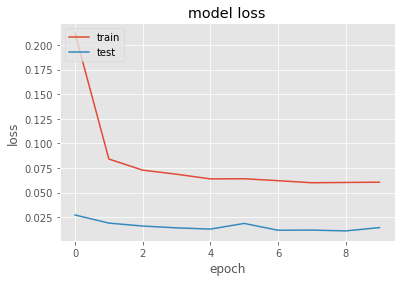

In [8]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
# computing errors

pred = model.predict(X_test, batch_size=n_batch)

#model.truncate()
errors = y_test - pred

mean = sum(errors)/len(errors)

cov = 0
for e in errors:
    cov += np.dot((e-mean).reshape(len(e), 1), (e-mean).reshape(1, len(e)))
cov /= len(errors)

print('mean : ', mean)
print('cov : ', cov)

mean :  [-0.03273051 -0.0307001  -0.03018202]
cov :  [[0.00703883 0.00717567 0.00620969]
 [0.00717567 0.01239978 0.01515936]
 [0.00620969 0.01515936 0.02318971]]


In [10]:
# calculate Mahalanobis distance
def Mahala_distantce(x,mean,cov):
    d = np.dot(x-mean,np.linalg.inv(cov))
    d = np.dot(d, (x-mean).T)
    return d

# anomaly detection
sub_seq, next_values = create_subseq(std_ecg[:5000], look_back, pred_length)
sub_seq = np.array(sub_seq)
next_values = np.array(next_values)

pred = model.predict(sub_seq, batch_size=n_batch)


errors = next_values - pred

m_dist = [0]*look_back 
print(m_dist)
for e in errors:
    m_dist.append(Mahala_distantce(e,mean,cov))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
errors.shape

(4987, 3)

In [12]:
m_dist

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4.898145917400636,
 5.77882079944337,
 4.330976678953053,
 2.30982690662922,
 1.7368046599796325,
 2.2029687619010323,
 2.2141112776325866,
 1.4837958201247168,
 0.1576796981087347,
 0.35221441006591714,
 1.0404867135565927,
 1.3412294375726757,
 0.8769971481456982,
 0.048964097482066544,
 0.9243804309908744,
 2.02135281391335,
 1.2477053764843253,
 1.66327193860297,
 1.7911658848789391,
 1.2461568188717287,
 1.0530824770837508,
 1.5821303230719965,
 1.8233635150672047,
 0.5615678220684747,
 0.5444095054498886,
 0.8530934136120589,
 0.6716510878679485,
 0.2945607010388608,
 0.4394571251999183,
 0.6020375571362236,
 0.6621421293214824,
 0.817529845665165,
 1.0761285202611481,
 1.6632531534996529,
 1.3073832074982636,
 1.9044439843346694,
 1.9069230423206098,
 2.271495151411836,
 2.1266940126717713,
 2.613533738425467,
 1.9329811718547478,
 2.438756916248466,
 1.763891494155288,
 1.0389581962639036,
 0.9671647576680117,
 0.7735105147009276,
 0.385

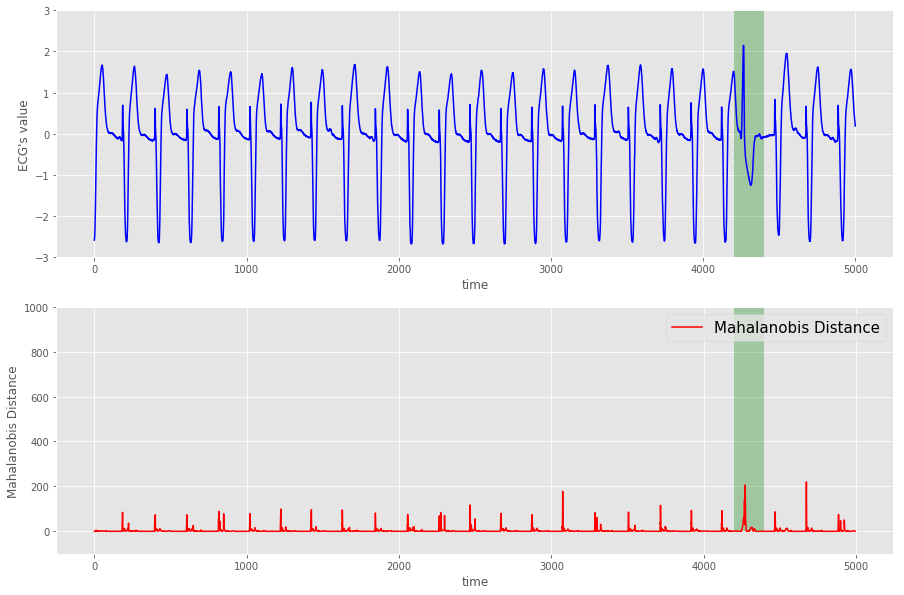

In [13]:
fig, axes = plt.subplots(nrows=2, figsize=(15,10))

axes[0].plot(std_ecg[:5000],color='b',label='original data')
axes[0].set_xlabel('time')
axes[0].set_ylabel('ECG\'s value' )
axes[0].set_ylim(-3, 3)
x = np.arange(4200,4400)
y1 = [-3]*len(x)
y2 = [3]*len(x)
axes[0].fill_between(x, y1, y2, facecolor='g', alpha=.3)

axes[1].plot(m_dist, color='r',label='Mahalanobis Distance')
axes[1].set_xlabel('time')
axes[1].set_ylabel('Mahalanobis Distance')
axes[1].set_ylim(-100, 1000)
y1 = [0]*len(x)
y2 = [1000]*len(x)
axes[1].fill_between(x, y1, y2, facecolor='g', alpha=.3)

plt.legend(fontsize=15)
plt.show()